In [1]:
import data.audio_dataset_v4 as data_utils_v4
import data.audio_dataset_v3 as data_utils_v3
import models.inversion_v1 as model_utils
from abstract_model import AbstractModel

import os
import shutil


import torch
import torchaudio
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix

from pytorch_lightning.core.saving import load_hparams_from_yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np

from torch.utils.data import DataLoader

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def _load_run(path):
    event_acc = event_accumulator.EventAccumulator(path)
    event_acc.Reload()
    data = {}

    for tag in sorted(event_acc.Tags()["scalars"]):
        x, y = [], []

        for scalar_event in event_acc.Scalars(tag):
            x.append(scalar_event.step)
            y.append(scalar_event.value)

        data[tag] = (np.asarray(x), np.asarray(y))
    return data

In [3]:
# L1 loss and amplitude prediction

algo = "inversion_v1"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
experiment_name = "overfitting_10_audio_files_with_l1_loss_and_amplitude"

AudioDatasetWithAmp = data_utils_v4.AudioDataset
AudioDatasetWithoutDB = data_utils_v3.AudioDataset
InversionV1 = model_utils.InversionV1

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

list_existing_hparams = []
list_of_train_loss = []

for version in versions:
    hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
    hparams_new = load_hparams_from_yaml(hparam_path)
    list_existing_hparams.append(hparams_new)
    list_of_train_loss.append(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['train_loss'][1]))

best_version, best_test_loss, best_hparams = versions[list_of_train_loss.index(min(list_of_train_loss))], list_of_train_loss[list_of_train_loss.index(min(list_of_train_loss))], list_existing_hparams[list_of_train_loss.index(min(list_of_train_loss))]

checkpoint_path = os.path.join(checkpoint_path, experiment_name, best_version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][0]

PATH = os.path.join(checkpoint_path, 'last.ckpt') 

model = AbstractModel.load_from_checkpoint(PATH, hparams=best_hparams, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithAmp,
                                            model = InversionV1(), 
                                            criterion = nn.L1Loss())

train_dataset = AudioDatasetWithAmp(root_dir=data_paths['train'], num_audios = best_hparams['train_num_audios'])
train_loader = DataLoader(train_dataset, batch_size=best_hparams['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]
    
    pred = model(emb)
    
    print("Embeddings shape: " + str(emb.shape))
    print("Expected Spectrogram shape: " + str(spec.shape))
    print("Predicted Spectrogram shape: " + str(pred.shape))
    if i == 0:
        break


Embeddings shape: torch.Size([6144])
Expected Spectrogram shape: torch.Size([1, 128, 199])
Predicted Spectrogram shape: torch.Size([1, 1, 128, 199])


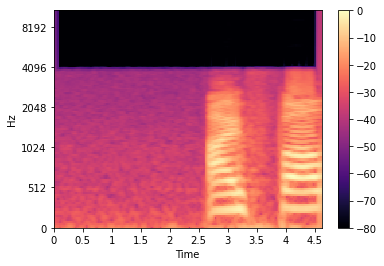

In [4]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[0,:,:].detach().numpy()), ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar()

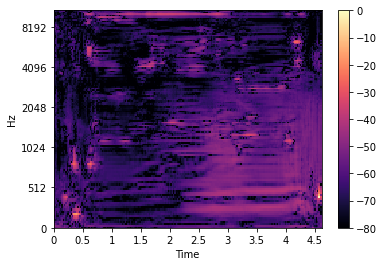

In [5]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(pred[0, 0,:,:].detach().numpy()), ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar()

In [25]:
# L1 loss and dB prediction

algo = "inversion_v1"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
experiment_name = "overfitting_10_audio_files_with_l1_loss"

AudioDatasetWithAmp = data_utils_v4.AudioDataset
AudioDatasetWithDB = data_utils_v3.AudioDataset
InversionV1 = model_utils.InversionV1

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

list_existing_hparams = []
list_of_train_loss = []

for version in versions:
    hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
    hparams_new = load_hparams_from_yaml(hparam_path)
    list_existing_hparams.append(hparams_new)
    list_of_train_loss.append(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['train_loss'][1]))

best_version, best_test_loss, best_hparams = versions[list_of_train_loss.index(min(list_of_train_loss))], list_of_train_loss[list_of_train_loss.index(min(list_of_train_loss))], list_existing_hparams[list_of_train_loss.index(min(list_of_train_loss))]

checkpoint_path = os.path.join(checkpoint_path, experiment_name, best_version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][0]

PATH = os.path.join(checkpoint_path, 'last.ckpt')  

model = AbstractModel.load_from_checkpoint(PATH, hparams=best_hparams, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithDB,
                                            model = InversionV1(), 
                                            criterion = nn.L1Loss())

train_dataset = AudioDatasetWithDB(root_dir=data_paths['train'], num_audios = best_hparams['train_num_audios'])
train_loader = DataLoader(train_dataset, batch_size=best_hparams['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]
    
    pred = model(emb)
    
    print("Embeddings shape: " + str(emb.shape))
    print("Expected Spectrogram shape: " + str(spec.shape))
    print("Predicted Spectrogram shape: " + str(pred.shape))
    if i == 0:
        break


Embeddings shape: torch.Size([6144])
Expected Spectrogram shape: torch.Size([1, 128, 199])
Predicted Spectrogram shape: torch.Size([1, 1, 128, 199])


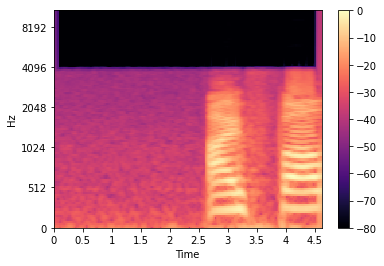

In [26]:
plt.subplots()
librosa.display.specshow(spec[0,:,:].detach().numpy(), y_axis='mel', x_axis='time')
plt.colorbar()

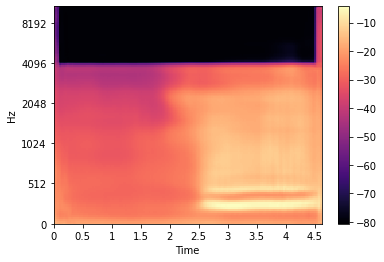

In [27]:
plt.subplots()
librosa.display.specshow(pred[0,0,:,:].detach().numpy(), y_axis='mel', x_axis='time')
plt.colorbar()

In [9]:
# MSE loss and amplitude prediction

algo = "inversion_v1"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
experiment_name = "overfitting_10_audio_files_with_MSE_and_amplitude"

AudioDatasetWithAmp = data_utils_v4.AudioDataset
AudioDatasetWithDB = data_utils_v3.AudioDataset
InversionV1 = model_utils.InversionV1

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

list_existing_hparams = []
list_of_train_loss = []

for version in versions:
    hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
    hparams_new = load_hparams_from_yaml(hparam_path)
    list_existing_hparams.append(hparams_new)
    list_of_train_loss.append(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['train_loss'][1]))

best_version, best_test_loss, best_hparams = versions[list_of_train_loss.index(min(list_of_train_loss))], list_of_train_loss[list_of_train_loss.index(min(list_of_train_loss))], list_existing_hparams[list_of_train_loss.index(min(list_of_train_loss))]

checkpoint_path = os.path.join(checkpoint_path, experiment_name, best_version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][0]

PATH = os.path.join(checkpoint_path, 'last.ckpt') 

model = AbstractModel.load_from_checkpoint(PATH, hparams=best_hparams, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithAmp,
                                            model = InversionV1(), 
                                            criterion = nn.L1Loss())

train_dataset = AudioDatasetWithAmp(root_dir=data_paths['train'], num_audios = best_hparams['train_num_audios'])
train_loader = DataLoader(train_dataset, batch_size=best_hparams['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]
    
    pred = model(emb)
    
    print("Embeddings shape: " + str(emb.shape))
    print("Expected Spectrogram shape: " + str(spec.shape))
    print("Predicted Spectrogram shape: " + str(pred.shape))
    if i == 0:
        break


Embeddings shape: torch.Size([6144])
Expected Spectrogram shape: torch.Size([1, 128, 199])
Predicted Spectrogram shape: torch.Size([1, 1, 128, 199])


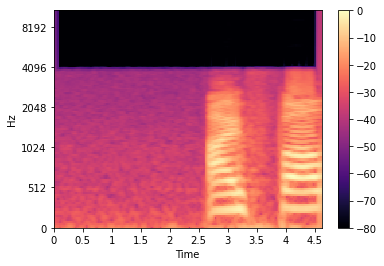

In [10]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(spec[0,:,:].detach().numpy()), ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar()

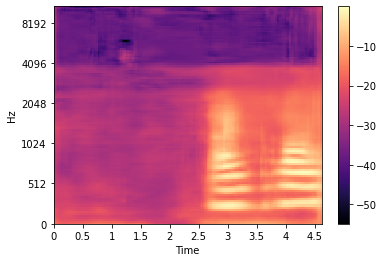

In [11]:
plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(np.abs(pred[0,0,:,:].detach().numpy()), ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar()

In [28]:
# MSE loss and dB prediction

algo = "inversion_v1"
data_path = "/scratch/prs392/incubator/data/LibriSpeech/"
checkpoint_path = f"/scratch/prs392/incubator/checkpoints/openl3_librispeech/{algo}/"
experiment_name = "overfitting_10_audio_files_with_MSE"

AudioDatasetWithAmp = data_utils_v4.AudioDataset
AudioDatasetWithDB = data_utils_v3.AudioDataset
InversionV1 = model_utils.InversionV1

data_paths = {}
data_paths['train'] = os.path.join(data_path, 'train-clean-360')
data_paths['val'] = os.path.join(data_path, 'dev-clean')
data_paths['test'] = os.path.join(data_path, 'test-clean')

d = os.path.join(checkpoint_path, experiment_name)
versions = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]

versions = sorted(versions)

list_existing_hparams = []
list_of_train_loss = []

for version in versions:
    hparam_path = os.path.join(checkpoint_path, experiment_name, version, 'hparams.yaml')
    hparams_new = load_hparams_from_yaml(hparam_path)
    list_existing_hparams.append(hparams_new)
    list_of_train_loss.append(min(_load_run(os.path.join(checkpoint_path, experiment_name, version))['train_loss'][1]))

best_version, best_test_loss, best_hparams = versions[list_of_train_loss.index(min(list_of_train_loss))], list_of_train_loss[list_of_train_loss.index(min(list_of_train_loss))], list_existing_hparams[list_of_train_loss.index(min(list_of_train_loss))]

checkpoint_path = os.path.join(checkpoint_path, experiment_name, best_version, 'checkpoints')
epoch_file = [o for o in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path,o))][0]

PATH = os.path.join(checkpoint_path, 'last.ckpt') 

model = AbstractModel.load_from_checkpoint(PATH, hparams=best_hparams, 
                                            data_paths = data_paths, 
                                            dataset_model = AudioDatasetWithDB,
                                            model = InversionV1(), 
                                            criterion = nn.L1Loss())

train_dataset = AudioDatasetWithDB(root_dir=data_paths['train'], num_audios = best_hparams['train_num_audios'])
train_loader = DataLoader(train_dataset, batch_size=best_hparams['batch_size'], shuffle=True, num_workers=4, pin_memory=True)

for i in range(len(train_dataset)):
    emb, spec, j = train_dataset[i]
    
    pred = model(emb)
    
#     print("Embeddings shape: " + str(emb.shape))
#     print("Expected Spectrogram shape: " + str(spec.shape))
#     print("Predicted Spectrogram shape: " + str(pred.shape))
    if i == 0:
        break


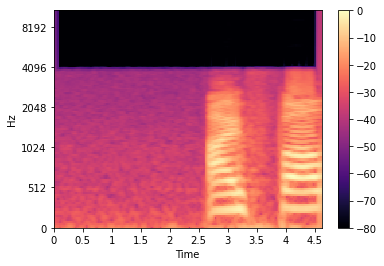

In [29]:
plt.subplots()
librosa.display.specshow(spec[0,:,:].detach().numpy(), y_axis='mel', x_axis='time')
plt.colorbar()

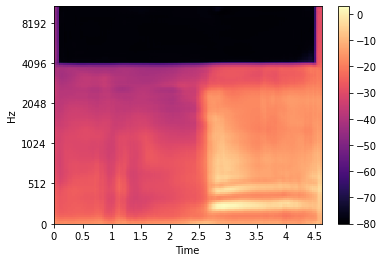

In [30]:
plt.subplots()
librosa.display.specshow(pred[0, 0,:,:].detach().numpy(), y_axis='mel', x_axis='time')
plt.colorbar()